In [1]:
# pip install bing-image-downloader

# !mkdir augmented

# # from bing_image_downloader import downloader

# downloader.download("lays package",limit=20)

# Overview
This notebook presents the task assigned during Slash's AI internship, which involves classifying images of products collected from their mobile application.

## Dataset:
The dataset comprises images of products available on the app in addition of some web scraped images to improve performance, they are categorized into the following labels:

- Fashion
- Nutrition
- Home

## Approach:
- Visualization & Preprocessing: Exploring the dataset through visualization techniques and preprocess the images for model training.

- Model Building: Constructing a classification model suitable for the task, considering the small size of the dataset.

- Model Training & Validation: Training the model on the preprocessed dataset while validating its performance on a separate validation set. Employing techniques to handle the small dataset size effectively.

- Data Augmentation: Applying data augmentation techniques to increase the diversity of the training dataset and enhance the model's ability to generalize.

- Model Improvement: Iterating on the model architecture and hyperparameters to improve its performance, considering insights gained from training and validation phases.

- Model Evaluation: Evaluating the final model's performance on a held-out test set, analyzing metrics such as accuracy, precision, recall, and F1-score to assess its effectiveness.

By following this structured approach, we aim to develop a robust image classification model despite the challenges posed by a small dataset.

# Imports

Importing libraries and packages need for the task in hand.

In [2]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from PIL import Image
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.regularizers import l2


C:\Temp\ipykernel_9756\2494895415.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
np.random.seed(0)
tf.random.set_seed(0)
random.seed(0)


# Visualization & Preprocessing 

## Loading images

Creating image loading function.

In [4]:
def load_images(folder, label_map):
    # creating two lists to store the images and labels
    images = []
    labels = []
    
    # loading the images from each folder in the dataset
    for category in os.listdir(folder):
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path):
            label = label_map[category]
            file_list = os.listdir(category_path)
            for filename in file_list:
                img_path = os.path.join(category_path, filename)
                image = cv2.imread(img_path)
                # resizing the images to create a standard and so that it can be suitable for the model input
                image = cv2.resize(image, (180, 180))
                # cv2 reads the image as BGR so we need to convert it back to RGB
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                labels.append(label)
    
    return np.array(images), np.array(labels)


In [5]:
data_folder = 'C:/Users/seif wael/Slash/data/'

# encoding the labels 
label_map = {'Fashion': 0, 'Home': 1, 'Nutrition': 2}

images, labels = load_images(data_folder,label_map)

print("Shape of images:", images.shape)
print("Shape of labels:", labels.shape)


Shape of images: (193, 180, 180, 3)
Shape of labels: (193,)


We have a total of 193 RGB images all resized to 180x180.

## Visualizing some samples of the data

In [6]:
def visualize_samples(images, labels, label_map, num_samples=5):
    num_classes = len(label_map)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(12, 12))
    
    for i, (class_name, class_idx) in enumerate(label_map.items()):
        class_images = images[labels == class_idx][:num_samples]
        for j in range(num_samples):
            axes[i, j].imshow(class_images[j])
            axes[i, j].set_title(class_name)
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

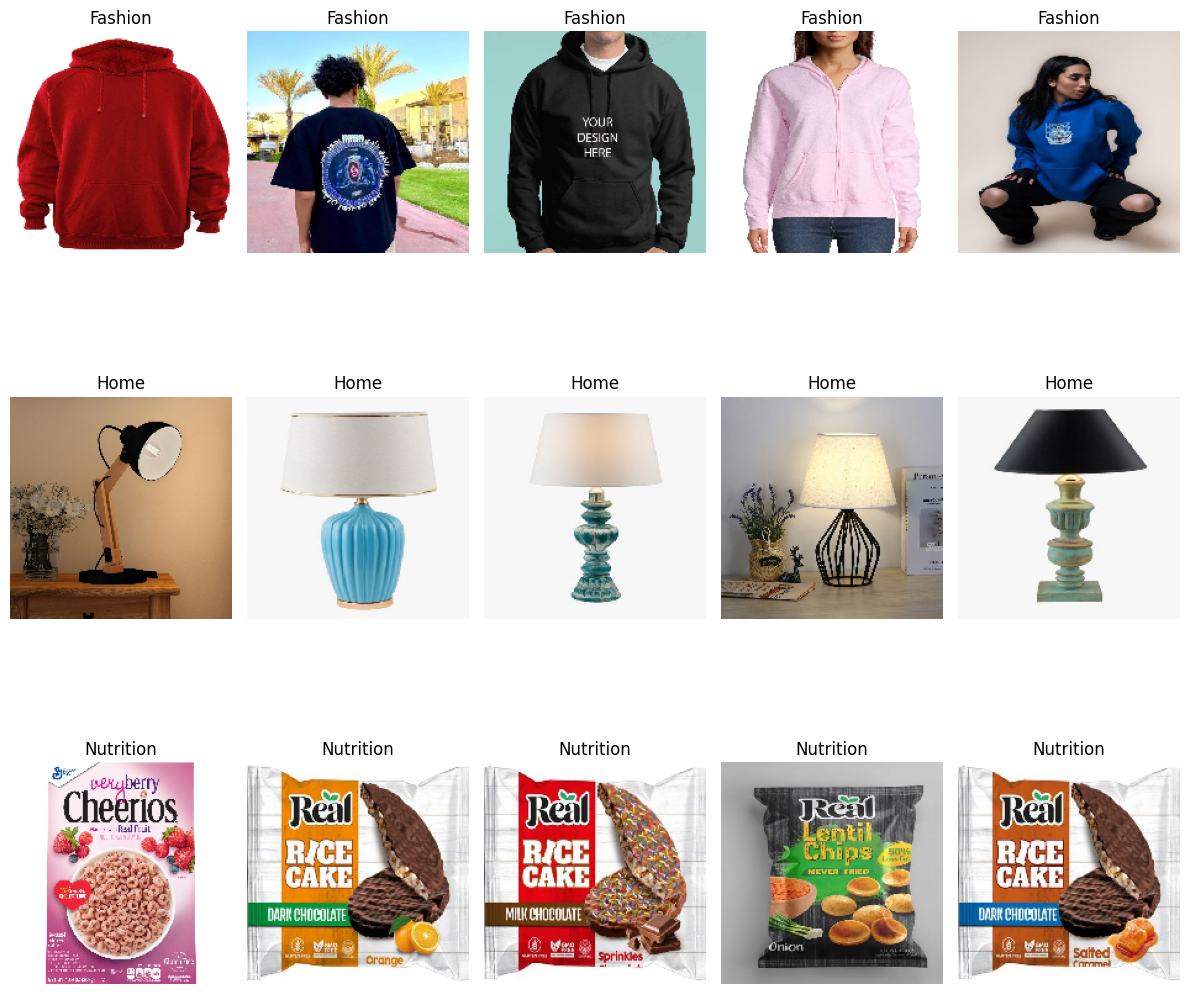

In [7]:
visualize_samples(images, labels, label_map)


## Visualizing data distribution 

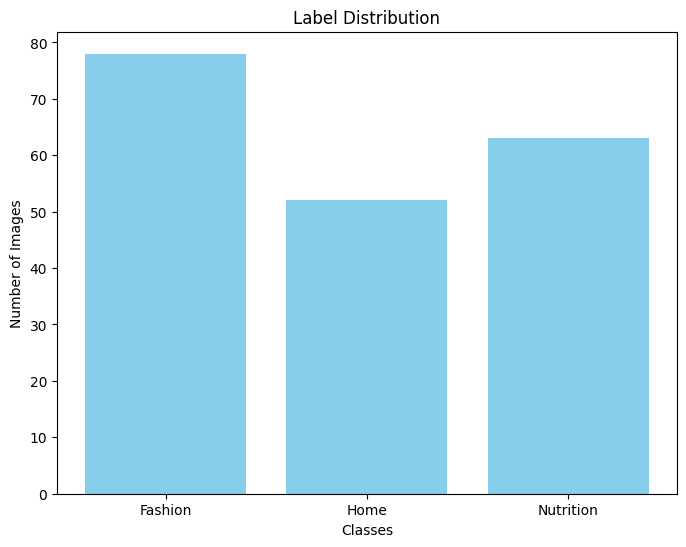

In [8]:
# decoding the labels so we can visualize it
label_map_decoded = {0: 'Fashion', 1: 'Home', 2: 'Nutrition'}

label_counts = {class_name: np.sum(labels == class_idx) for class_idx, class_name in label_map_decoded.items()}

plt.figure(figsize=(8, 6))
plt.bar(label_counts.keys(), label_counts.values(), color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Label Distribution')
plt.xticks(range(len(label_map_decoded)), label_map_decoded.values())
plt.show()


- `Fashion` has the most images, while `Home` has the least.
- The difference in each class's size is not huge, but could cause some problems while modelling due to bias.

## Data Splitting

Now, we need to split the data to `Train`, `Validation` and `Test` sets so that we can start building and training our model.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Creating folders for `Train`, `Validation` and `Test` sets.

In [10]:
train_folder = 'Train'
val_folder = 'Validation'
test_folder = 'Test'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)


def copy_images_to_folder(images, labels, folder):
    for i, (image, label) in enumerate(zip(images, labels)):
        class_name = label_map_decoded[label]
        class_folder = os.path.join(folder, class_name)
        os.makedirs(class_folder, exist_ok=True)
        img_filename = f'{class_name}_{i}.jpg'
        img_path = os.path.join(class_folder, img_filename)
        image_pil = Image.fromarray(image)
        image_pil.save(img_path)


In [11]:
copy_images_to_folder(X_train, y_train, train_folder)
copy_images_to_folder(X_val, y_val, val_folder)
copy_images_to_folder(X_test, y_test, test_folder)

## Data Normalization 

We need to normalize the data so that the pixel values range from 0 to 1 instead of 0 to 255, this step is crucial as it helps improve the stability and generalization of the model.

In [12]:
X_train=X_train/255
X_val=X_val/255
X_test=X_test/255

In [13]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(123, 180, 180, 3)
(31, 180, 180, 3)
(39, 180, 180, 3)


In [14]:
num_classes=len(set(y_train))
print("Number of classes = ",num_classes)

Number of classes =  3


In [15]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# CNN Model

In [16]:
input_shape=(180,180,3)
batch_size=32

Building a baseline `CNN` model, to see how it goes.

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 118336)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [18]:
model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history=model.fit(X_train,
                 y_train,
                 batch_size=batch_size,
                 epochs=100,
                 validation_data=(X_val,y_val),
                 callbacks=[early_stopping])

Epoch 1/100
4/4 [==============================] - 7s 393ms/step - loss: 7.9429 - accuracy: 0.3902 - val_loss: 5.6224 - val_accuracy: 0.5161
Epoch 2/100
4/4 [==============================] - 0s 80ms/step - loss: 4.1014 - accuracy: 0.4797 - val_loss: 0.8942 - val_accuracy: 0.4839
Epoch 3/100
4/4 [==============================] - 0s 102ms/step - loss: 1.4773 - accuracy: 0.4146 - val_loss: 0.8286 - val_accuracy: 0.5161
Epoch 4/100
4/4 [==============================] - 0s 94ms/step - loss: 0.7425 - accuracy: 0.6911 - val_loss: 0.6858 - val_accuracy: 0.8387
Epoch 5/100
4/4 [==============================] - 0s 92ms/step - loss: 0.5603 - accuracy: 0.7967 - val_loss: 0.6128 - val_accuracy: 0.8710
Epoch 6/100
4/4 [==============================] - 0s 71ms/step - loss: 0.4773 - accuracy: 0.7480 - val_loss: 0.9190 - val_accuracy: 0.7097
Epoch 7/100
4/4 [==============================] - 0s 92ms/step - loss: 0.2131 - accuracy: 0.9512 - val_loss: 0.4119 - val_accuracy: 0.8065
Epoch 8/100
4/4 [=

## Confusion Matrix 

2/2 [==============================] - 0s 109ms/step
Test Accuracy: 0.8461538461538461


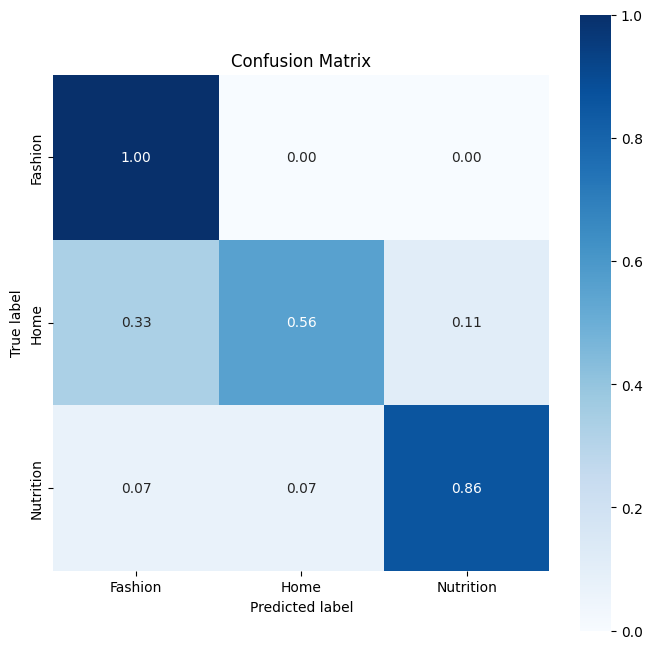

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=1)

accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Test Accuracy:", accuracy)

class_names = ['Fashion', 'Home', 'Nutrition']

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

The model is overfitting as the training accuracy is much higher than the validation & test sets.

## Plotting model's loss and accuracy

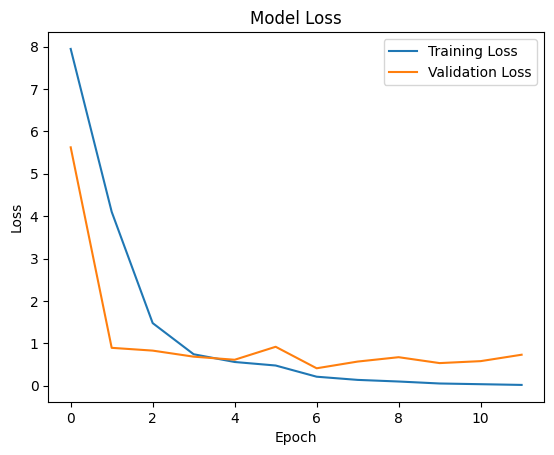

In [20]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

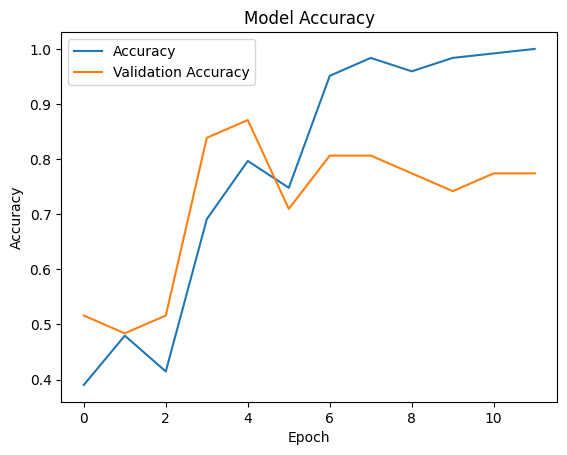

In [21]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Data Augmentation 

Augmenting the data to improve model's performance.

In [22]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.5, 1.5],
    rescale=1./255
)

val_datagen = ImageDataGenerator(rescale=1./255)

image_size=180

train_generator = datagen.flow_from_directory(
    train_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_folder,
    target_size=(image_size, image_size),
    batch_size=batch_size,  
    class_mode='categorical'
)

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [23]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', padding='same', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 128)       204928    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 128)     

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
epochs = 200

history = model.fit(
    train_generator,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/200
8/8 [==============================] - 13s 837ms/step - loss: 1.4480 - accuracy: 0.4417 - val_loss: 1.0943 - val_accuracy: 0.2833 - lr: 1.0000e-04
Epoch 2/200
8/8 [==============================] - 3s 389ms/step - loss: 1.1083 - accuracy: 0.5000 - val_loss: 1.0856 - val_accuracy: 0.2833 - lr: 1.0000e-04
Epoch 3/200
8/8 [==============================] - 2s 210ms/step - loss: 1.0421 - accuracy: 0.5917 - val_loss: 1.0799 - val_accuracy: 0.3167 - lr: 1.0000e-04
Epoch 4/200
8/8 [==============================] - 2s 249ms/step - loss: 0.7997 - accuracy: 0.6583 - val_loss: 1.0661 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 5/200
8/8 [==============================] - 2s 180ms/step - loss: 0.8432 - accuracy: 0.6708 - val_loss: 1.0623 - val_accuracy: 0.6167 - lr: 1.0000e-04
Epoch 6/200
8/8 [==============================] - 2s 210ms/step - loss: 0.8603 - accuracy: 0.6667 - val_loss: 1.0535 - val_accuracy: 0.6667 - lr: 1.0000e-04
Epoch 7/200
8/8 [==============================] - 

## Confusion Matrix

2/2 [==============================] - 0s 305ms/step
Test Accuracy: 0.9743589743589743


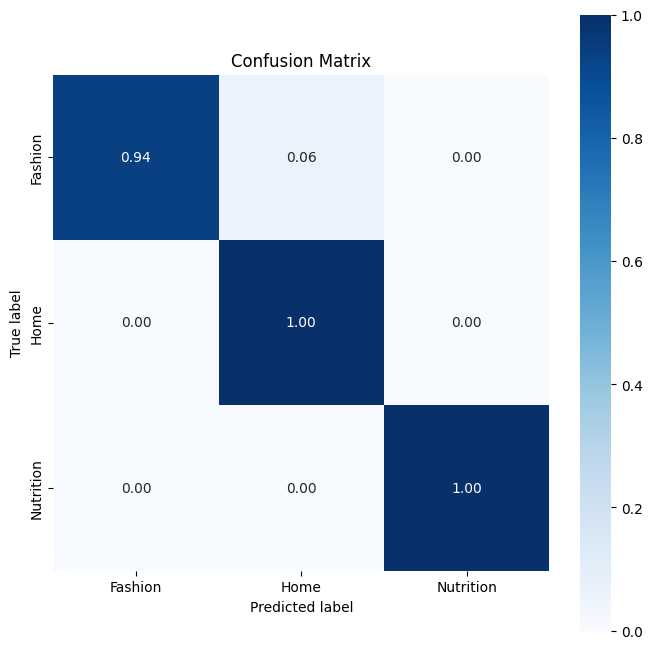

In [29]:
y_pred = np.argmax(model.predict(X_test), axis=1)

accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
print("Test Accuracy:", accuracy)

class_names = ['Fashion', 'Home', 'Nutrition']

cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


## Plotting model's loss and accuracy

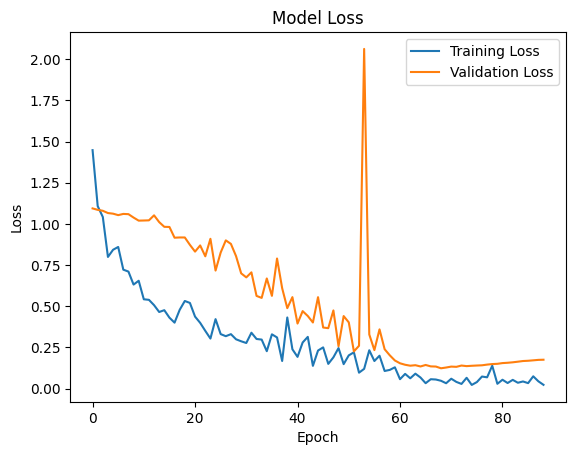

In [26]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

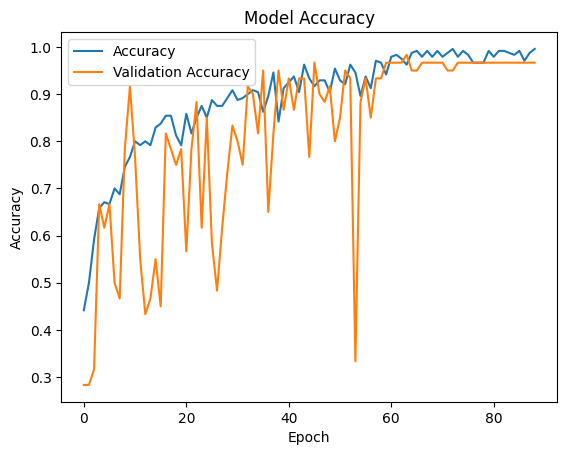

In [27]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Misclassified labels

2/2 [==============================] - 0s 25ms/step


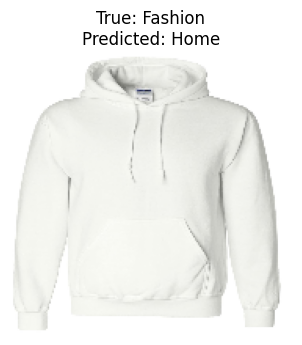

In [28]:
y_test_decoded = np.argmax(y_test, axis=1)

y_pred = np.argmax(model.predict(X_test), axis=1)

misclassified_indices = np.where(y_pred != y_test_decoded)[0]

plt.figure(figsize=(15, 15))  
num_misclassified = len(misclassified_indices)
num_rows = (num_misclassified // 5) + 1  
for i, idx in enumerate(misclassified_indices):
    plt.subplot(num_rows, 5, i + 1)  
    plt.imshow(X_test[idx])
    plt.title(f"True: {class_names[y_test_decoded[idx]]}\nPredicted: {class_names[y_pred[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
